In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
import seaborn as sns

In [2]:
data = pd.read_csv("Life Expectancy Data.csv")

In [3]:
print("Dataset contains rows: {}, columns: {}".format(data.shape[0],data.shape[1]))
data.head()

Dataset contains rows: 2938, columns: 22


Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0    6.0               8.16         65.0        0.1  584.259210  33736494.0   
1   58.0               8.18         62.0        0.1  612.696514    327582.0   
2   62.0               8.13         64.0        0.1  631.744976  31731688.0   
3   67.0               8.52         67.0        0.1  669.959000   3696958.0   
4   68.0               7.87         68.0        0.1   63.537231   2978599.0   

    thinness  1-19 years   thinness 5-9 years  \
0                   17.2                 17.3   
1                   17.5                 17.5   
2                   17.7                 17.7   
3                   17.9                 18.0   
4                   18.2                 18.2   

   Income composition of resources  Schooling  
0                            0.479       10.1  
1                            0.476       10.0  
2                            0.470        9.9  
3                            0.463        9.8  
4                            0.454        9.5  

[5 rows x 22 columns]

In [4]:
# check data types
data.dtypes

Country                             object
Year                                 int64
Status                              object
Life expectancy                    float64
Adult Mortality                    float64
infant deaths                        int64
Alcohol                            float64
percentage expenditure             float64
Hepatitis B                        float64
Measles                              int64
 BMI                               float64
under-five deaths                    int64
Polio                              float64
Total expenditure                  float64
Diphtheria                         float64
 HIV/AIDS                          float64
GDP                                float64
Population                         float64
 thinness  1-19 years              float64
 thinness 5-9 years                float64
Income composition of resources    float64
Schooling                          float64
dtype: object

Visualization

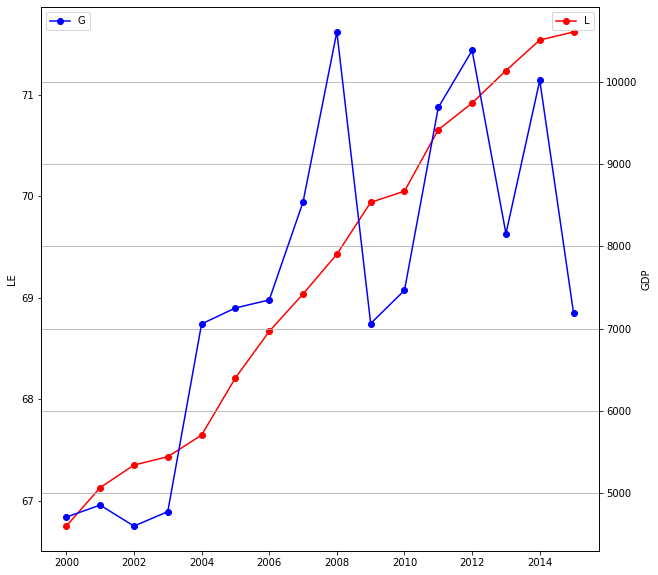

In [5]:
# See the mean of life expectancy and GDP of every country over every year
mean_le = data.groupby("Year")["Life expectancy "].mean()
mean_gdp = data.groupby("Year")["GDP"].mean()

fig2 = plt.figure(figsize = (10,10))
ax = fig2.add_subplot()
ax2 = ax.twinx()

ax.plot(mean_le, color = 'red', marker = 'o')
ax2.plot(mean_gdp, color = 'blue', marker = 'o')

ax.set_ylabel("LE")
ax2.set_ylabel("GDP")
ax.legend("LE", loc = 1)
ax2.legend("GDP", loc = 2)
plt.xlabel("Year")
plt.grid(True)

In [6]:
# get the top 10 life ecpentancy and gdp according to the country
t10_le = data.groupby("Country")["Life expectancy "].mean().sort_values(ascending = False)[:10]
t10_le_gdp = data.groupby("Country")["GDP"].mean()[t10_le.index]

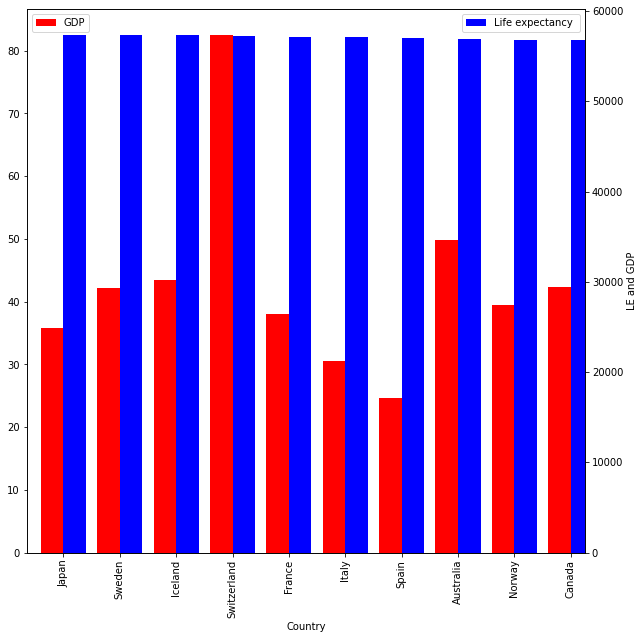

In [7]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

width = 0.4
t10_le.plot(kind = 'bar', ax = ax, color = 'blue', position = 0, width = width)
t10_le_gdp.plot(kind = 'bar', ax = ax2, color = 'red', position = 1, width = width)
plt.xlabel("Country")
plt.ylabel("LE and GDP")

ax.legend(loc = 1)
ax2.legend(loc = 2)
plt.show()

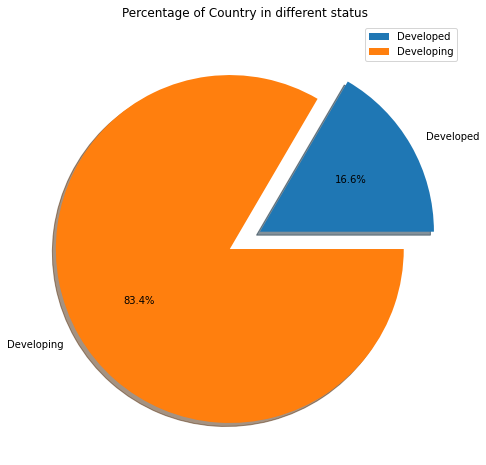

In [8]:
# Check the distribution of developed and developing country
developed_country_cnt = len(data[data.Status == "Developed"]["Country"].unique())
developing_country_cnt = len(data[data.Status == "Developing"]["Country"].unique())
status_cnt = [developed_country_cnt, developing_country_cnt]

# plot pie chart
exploder = [0.1, 0.1]
plt.figure(figsize = (8,8))
plt.title("Percentage of Country in different status")
plt.pie(status_cnt, labels = ["Developed", "Developing"],
        explode = exploder, shadow = True, autopct = '%1.1f%%')
plt.legend()
plt.show()

Missing Values

In [9]:
print("Missing Column Value Percentage\n")
missing_value = []
for col in data.columns:
    missing_pct = data[col].isnull().sum()
    if missing_pct == 0: continue
    missing_value.append(col)
    print("{} - {}%".format(col, missing_pct))

Missing Column Value Percentage

Life expectancy  - 10%
Adult Mortality - 10%
Alcohol - 194%
Hepatitis B - 553%
 BMI  - 34%
Polio - 19%
Total expenditure - 226%
Diphtheria  - 19%
GDP - 448%
Population - 652%
 thinness  1-19 years - 34%
 thinness 5-9 years - 34%
Income composition of resources - 167%
Schooling - 163%


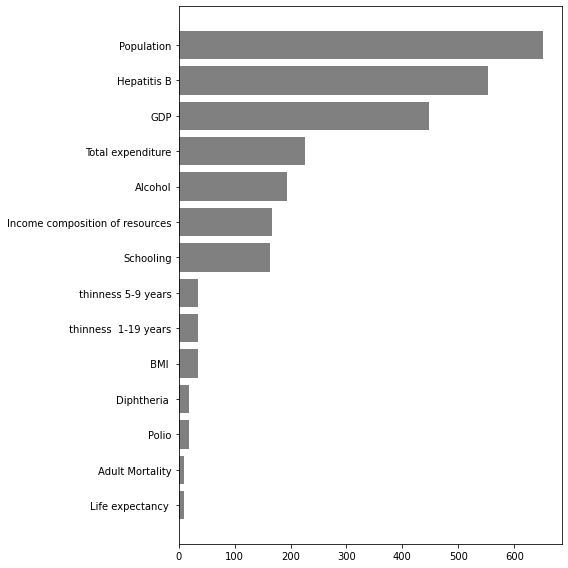

In [10]:
# plot the missing value bar
pct = np.array([data[col].isnull().sum() for col in missing_value])
sort_index = np.argsort(pct)
sort_value = np.sort(pct)
sort_col = [missing_value[index] for index in sort_index]

plt.figure(figsize = (8,8))
plt.barh(y = sort_col, width = sort_value, linewidth = 1, color = "gray")
plt.tight_layout()
plt.show()

In [11]:
# reset index
data.dropna(subset = ["Life expectancy "], inplace = True)
data.reset_index(drop = True, inplace = True)

In [12]:
# handle missing values
def fill_mean(df):
    miss_col = data.columns[df.isnull().any()]
    for col in miss_col:
        miss_val = df[col].isnull()
        miss_index = miss_val[miss_val == True].index
        # handle according to country
        for index in miss_index:
            country = df.loc[index, "Country"]
            col_mean = df[df.Country == country][col].mean()
            if col_mean is np.nan:
                df[col].fillna(value = df[col].mean(), inplace = True)
                break
            df.loc[index, col] = col_mean
    
    return df

In [13]:
# fill nan values with mean
clean_data = fill_mean(data)
clean_data.isnull().any() # - check still any missing values

Country                            False
Year                               False
Status                             False
Life expectancy                    False
Adult Mortality                    False
infant deaths                      False
Alcohol                            False
percentage expenditure             False
Hepatitis B                        False
Measles                            False
 BMI                               False
under-five deaths                  False
Polio                              False
Total expenditure                  False
Diphtheria                         False
 HIV/AIDS                          False
GDP                                False
Population                         False
 thinness  1-19 years              False
 thinness 5-9 years                False
Income composition of resources    False
Schooling                          False
dtype: bool

Feature Selection

In [14]:
def mutual_info(df):
    y = df["Life expectancy "]
    x = df.drop(columns = ["Life expectancy "], axis = 1)
    x = x.select_dtypes(exclude = "object")
    
    # calculate mi scores
    mi_scores = mutual_info_regression(x, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=x.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    print(mi_scores)
    
    # visualization
    mi_scores.plot(kind = 'bar', figsize = (12,10), colormap = 'coolwarm_r')
    return mi_scores

Adult Mortality                    1.262188
Income composition of resources    0.930290
 thinness 5-9 years                0.777621
 thinness  1-19 years              0.776026
Schooling                          0.693552
 BMI                               0.574881
 HIV/AIDS                          0.524413
infant deaths                      0.439015
under-five deaths                  0.434232
GDP                                0.354972
Alcohol                            0.343797
Polio                              0.331248
Diphtheria                         0.307531
percentage expenditure             0.293700
Total expenditure                  0.252782
Hepatitis B                        0.243230
Population                         0.150541
Measles                            0.117468
Year                               0.072006
Name: MI Scores, dtype: float64


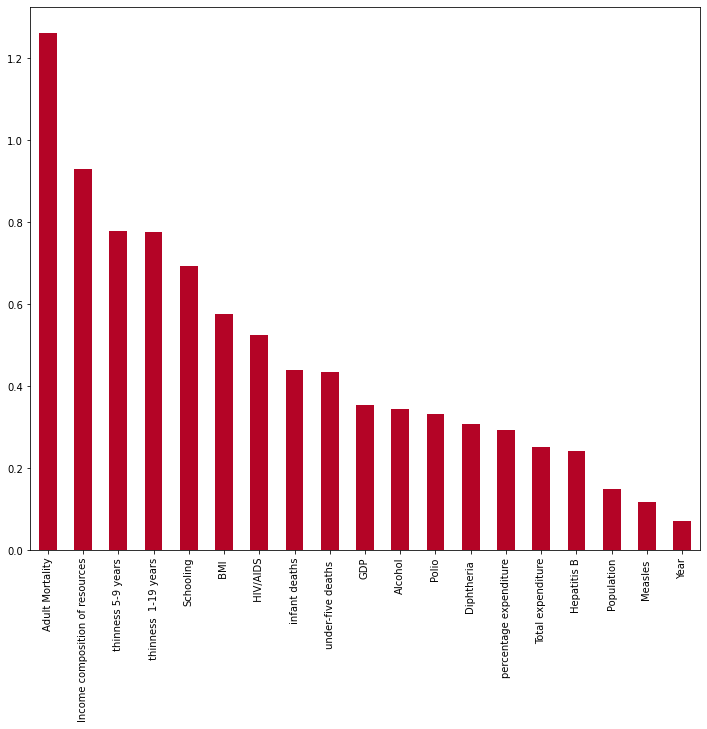

In [15]:
mi_scores = mutual_info(clean_data)

In [16]:
# eliminate low mi scores
clean_data.drop(columns = mi_scores.index[10:], inplace = True)
clean_data.head()

Country      Status  Life expectancy   Adult Mortality  infant deaths  \
0  Afghanistan  Developing              65.0            263.0             62   
1  Afghanistan  Developing              59.9            271.0             64   
2  Afghanistan  Developing              59.9            268.0             66   
3  Afghanistan  Developing              59.5            272.0             69   
4  Afghanistan  Developing              59.2            275.0             71   

    BMI   under-five deaths    HIV/AIDS         GDP   thinness  1-19 years  \
0   19.1                  83        0.1  584.259210                   17.2   
1   18.6                  86        0.1  612.696514                   17.5   
2   18.1                  89        0.1  631.744976                   17.7   
3   17.6                  93        0.1  669.959000                   17.9   
4   17.2                  97        0.1   63.537231                   18.2   

    thinness 5-9 years  Income composition of resources  Schooling  
0                 17.3                            0.479       10.1  
1                 17.5                            0.476       10.0  
2                 17.7                            0.470        9.9  
3                 18.0                            0.463        9.8  
4                 18.2                            0.454        9.5

In [17]:
y = clean_data.pop("Life expectancy ")
x = clean_data

One Hot Encoding

In [18]:
# one hot encoding
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
obj_cols = x.select_dtypes("object")
clean_data.drop(columns = obj_cols, inplace = True)

ohe_cols = ohe.fit_transform(obj_cols)
print(ohe_cols)

[[1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 0. 1.]]


Feature Scaling

In [19]:
scaler = MinMaxScaler()
scale_feature = clean_data.select_dtypes(exclude = "object")
scaled = scaler.fit_transform(scale_feature)
print(scaled)

[[0.36288089 0.03444444 0.23629243 ... 0.60350877 0.50527426 0.48792271]
 [0.37396122 0.03555556 0.22976501 ... 0.61052632 0.5021097  0.48309179]
 [0.36980609 0.03666667 0.2232376  ... 0.61754386 0.49578059 0.47826087]
 ...
 [0.09972299 0.01388889 0.33028721 ... 0.04210526 0.45042194 0.48309179]
 [0.94875346 0.01388889 0.32506527 ... 0.05614035 0.45042194 0.47342995]
 [0.91966759 0.01333333 0.31984334 ... 0.38947368 0.45780591 0.47342995]]


In [20]:
# append onehotencoding and scaled data
cols_name = clean_data.columns

scaled_df = pd.DataFrame(scaled, columns = cols_name)
x = pd.concat((scaled_df, pd.DataFrame(ohe_cols)),axis = 1)
x

Adult Mortality  infant deaths      BMI   under-five deaths    HIV/AIDS  \
0            0.362881       0.034444  0.236292              0.0332   0.000000   
1            0.373961       0.035556  0.229765              0.0344   0.000000   
2            0.369806       0.036667  0.223238              0.0356   0.000000   
3            0.375346       0.038333  0.216710              0.0372   0.000000   
4            0.379501       0.039444  0.211488              0.0388   0.000000   
...               ...            ...       ...                 ...        ...   
2923         1.000000       0.015000  0.340731              0.0168   0.663366   
2924         0.988920       0.014444  0.335509              0.0164   0.724752   
2925         0.099723       0.013889  0.330287              0.0160   0.786139   
2926         0.948753       0.013889  0.325065              0.0156   0.831683   
2927         0.919668       0.013333  0.319843              0.0156   0.859406   

           GDP   thinness  1-19 years   thinness 5-9 years  \
0     0.004889               0.619565             0.603509   
1     0.005127               0.630435             0.610526   
2     0.005287               0.637681             0.617544   
3     0.005608               0.644928             0.628070   
4     0.000519               0.655797             0.635088   
...        ...                    ...                  ...   
2923  0.003799               0.336957             0.326316   
2924  0.003790               0.351449             0.343860   
2925  0.000467               0.039855             0.042105   
2926  0.004589               0.054348             0.056140   
2927  0.004579               0.394928             0.389474   

      Income composition of resources  Schooling  ...  175  176  177  178  \
0                            0.505274   0.487923  ...  0.0  0.0  0.0  0.0   
1                            0.502110   0.483092  ...  0.0  0.0  0.0  0.0   
2                            0.495781   0.478261  ...  0.0  0.0  0.0  0.0   
3                            0.488397   0.473430  ...  0.0  0.0  0.0  0.0   
4                            0.478903   0.458937  ...  0.0  0.0  0.0  0.0   
...                               ...        ...  ...  ...  ...  ...  ...   
2923                         0.429325   0.444444  ...  0.0  0.0  0.0  0.0   
2924                         0.440928   0.458937  ...  0.0  0.0  0.0  0.0   
2925                         0.450422   0.483092  ...  0.0  0.0  0.0  0.0   
2926                         0.450422   0.473430  ...  0.0  0.0  0.0  0.0   
2927                         0.457806   0.473430  ...  0.0  0.0  0.0  0.0   

      179  180  181  182  183  184  
0     0.0  0.0  0.0  0.0  0.0  1.0  
1     0.0  0.0  0.0  0.0  0.0  1.0  
2     0.0  0.0  0.0  0.0  0.0  1.0  
3     0.0  0.0  0.0  0.0  0.0  1.0  
4     0.0  0.0  0.0  0.0  0.0  1.0  
...   ...  ...  ...  ...  ...  ...  
2923  0.0  0.0  0.0  1.0  0.0  1.0  
2924  0.0  0.0  0.0  1.0  0.0  1.0  
2925  0.0  0.0  0.0  1.0  0.0  1.0  
2926  0.0  0.0  0.0  1.0  0.0  1.0  
2927  0.0  0.0  0.0  1.0  0.0  1.0  

[2928 rows x 195 columns]

In [21]:
# turn y into scaled output
Y = y.map(lambda value: 0 if value <= y.max()*0.5 else (
          1 if value > y.max()*0.5 and value <= y.max()*0.8 else 2))
Y.unique()

array([1, 2, 0])

In [22]:
# split train and test
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size = 0.1, random_state = 10)

Lets try with Boosting and Bagging

In [26]:
svc = SVC(C = 3.0, gamma = "auto", kernel = "linear")
ADA = AdaBoostClassifier(svc, n_estimators = 10, algorithm = 'SAMME', learning_rate = 1.0)
BAG = BaggingClassifier(svc, n_estimators = 5, max_samples = 0.5)

In [27]:
ADA.fit(x_train, y_train)
BAG.fit(x_train, y_train)

BaggingClassifier(base_estimator=SVC(C=3.0, gamma='auto', kernel='linear'),
                  max_samples=0.5, n_estimators=5)

In [29]:
from sklearn.metrics import accuracy_score

y_pred_ada = ADA.predict(x_test)
y_pred_bag = BAG.predict(x_test)
print("Boosting Accuracy : {}\nBagging Accuracy : {}".format(accuracy_score(y_test,y_pred_ada),
                                                             accuracy_score(y_test,y_pred_bag)))

Boosting Accuracy : 0.8191126279863481
Bagging Accuracy : 0.9351535836177475
